In [2]:
import pickle
import os
import gensim
import gensim.corpora as corpora
import glob
import gzip
import sklearn.preprocessing
import pandas as pd
import matplotlib.pyplot as plt

import pyLDAvis
%matplotlib inline
pyLDAvis.enable_notebook()

# Notes

Seems like model with 30 topics is best!

# Load models, coherence scores, and corpus data

In [3]:
MODEL_DIR = "/data/ddmg/users/kmatton/nlp_project/nlp-fertility-forums-project/data/topic_model"
MODEL_NAME = "downsample_data"
CORPUS_DIR = "/data/ddmg/users/kmatton/nlp_project/nlp-fertility-forums-project/data/topic_model"
CORPUS_NAME = "topic_model_train"

/data/ddmg/users/kmatton/.conda/envs/ff/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
model_list = []
for model_path in glob.glob(os.path.join(MODEL_DIR, '{}*.mdl'.format(MODEL_NAME))):
    # get number of topics
    model_file_name = os.path.basename(model_path)
    parts = model_file_name.split("_")
    k = parts[-2]
    # load model
    model = gensim.models.wrappers.ldamallet.LdaMallet.load(model_path)
    model_list.append((int(k), model))

/data/ddmg/users/kmatton/.conda/envs/ff/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
coherence_df = pd.DataFrame(columns=["num topics", "coherence score"])
for coherence_path in glob.glob(os.path.join(MODEL_DIR, '{}*coherence_scores*.csv'.format(MODEL_NAME))):
    # read file
    df = pd.read_csv(coherence_path, index_col=0)
    # append to coherence_df
    coherence_df = coherence_df.append(df, ignore_index=True)

/data/ddmg/users/kmatton/.conda/envs/ff/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
data_df = pd.read_csv(os.path.join(CORPUS_DIR, "{}_corpus.csv").format(CORPUS_NAME), index_col=0)

/data/ddmg/users/kmatton/.conda/envs/ff/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
vocab_dict =  corpora.dictionary.Dictionary.load(os.path.join(CORPUS_DIR, "{}_vocab.dct".format(CORPUS_NAME)))

/data/ddmg/users/kmatton/.conda/envs/ff/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Analyze Model Coherence Scores

In [8]:
def plot_coherence_scores(coherence_df):
    """
    Create a plot displaying coherence scores for each k value.
    :param coherence_df: pandas DataFrame with columns "num topics" and "coherence score"
    """
    plt.plot(coherence_df["num topics"].values, coherence_df["coherence score"].values)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend("coherence_values", loc="best")
    plt.show()

/data/ddmg/users/kmatton/.conda/envs/ff/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/data/ddmg/users/kmatton/.conda/envs/ff/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


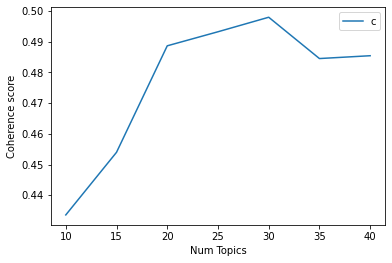

In [9]:
plot_coherence_scores(coherence_df)

# Visualize Topics and Keywords

Visualization procedure adapated from https://jeriwieringa.com/2018/07/17/pyLDAviz-and-Mallet/.

In [10]:
def prepare_model_data_for_viz(model):
    """
    Extract information from LDA topic model needed for pyLDA visualization.
    :param model: gensim Mallet LDA topic model
    return:
        vis_data: pyLDAvis prepared data object, a named tuple containing all the data structures required to create the visualization.
                    (topic term matrix, document topic matrix, doc lengths, vocab, and term frequencies)
    """
    # get path to model state file
    model_statefile = model.fstate()
    
    # load model state info
    alpha, beta = _extract_params(model_statefile)
    model_df = _state_to_df(model_statefile)
    
    # create data objects needed for pyLDA viz
    # (1) doc lengths
    doc_len_df = model_df.groupby('#doc')['type'].count().reset_index(name ='doc_length')
    
    # (2) vocab and (3) term frequencies
    vocab_df = model_df['type'].value_counts().reset_index()
    vocab_df.columns = ['type', 'term_freq']
    vocab_df = vocab_df.sort_values(by='type', ascending=True)
    
    # (3) topic-term distribution matrix
    tt_df = model_df.groupby(['topic', 'type'])['type'].count().reset_index(name ='token_count')
    tt_df = tt_df.sort_values(by='type', ascending=True)
    # normalize and smooth by beta (prior on word distribution for each topic)
    tt_matrix = _pivot_and_smooth(tt_df, beta, 'topic', 'type', 'token_count')
    
    # (4) document-topic distribution matrix
    dt_df = model_df.groupby(['#doc', 'topic'])['topic'].count().reset_index(name ='topic_count')
    # normalize and smooth by alpha (prior on topic distribution for each document)
    dt_matrix = _pivot_and_smooth(dt_df, alpha, '#doc', 'topic', 'topic_count')
    
    model_data = {'topic_term_dists': tt_matrix, 
                  'doc_topic_dists': dt_matrix,
                  'doc_lengths': list(doc_len_df['doc_length']),
                  'vocab': list(vocab_df['type']),
                  'term_frequency': list(vocab_df['term_freq'])
                 }
    vis_data = pyLDAvis.prepare(**model_data)
    return vis_data

/data/ddmg/users/kmatton/.conda/envs/ff/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
def _extract_params(statefile):
    """
    Extract the alpha and beta values from the statefile.
    :param statefile (str): Path to  MALLET model statefile.
    return:
        alpha (list of floats) --> one value for each of the k topics
        beta (float) --> single value, as single value is repeated for all num words dimensions
    """
    with gzip.open(statefile, 'r') as state:
        params = [x.decode('utf8').strip() for x in state.readlines()[1:3]]
    alpha = [float(x) for x in params[0].split(":")[1].strip().split(" ")]
    beta = float(params[1].split(":")[1])
    return alpha, beta

/data/ddmg/users/kmatton/.conda/envs/ff/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
def _state_to_df(statefile):
    """
    Transform state file into pandas dataframe.
    The MALLET statefile is tab-separated, and the first two rows contain the alpha and beta hypterparamters.
    param: statefile (str): Path to statefile produced by MALLET.
    return:
        df (dataframe): topic assignment for each token in each document of the model
    """
    df = pd.read_csv(statefile,compression='gzip', sep=' ', skiprows=[1,2])
    # convert "type" column to be all of type string --> otherwise "nan" token gets put as a float
    df['type'] = df.type.astype(str)
    return df

/data/ddmg/users/kmatton/.conda/envs/ff/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
def _pivot_and_smooth(df, smooth_value, rows_variable, cols_variable, values_variable):
    """
    Turns the pandas dataframe into a data matrix.
    :param df (dataframe): aggregated dataframe 
    :param smooth_value (float): value to add to the matrix to account for the priors
    :param rows_variable (str): name of dataframe column to use as the rows in the matrix
    :param cols_variable (str): name of dataframe column to use as the columns in the matrix
        values_variable(str): name of the dataframe column to use as the values in the matrix
    return:
        dataframe: pandas matrix that has been normalized (w/ smoothing) on the rows.
    """
    matrix = df.pivot(index=rows_variable, columns=cols_variable, values=values_variable).fillna(value=0)
    matrix = matrix.values + smooth_value
    
    normed = sklearn.preprocessing.normalize(matrix, norm='l1', axis=1)
    
    return normed

/data/ddmg/users/kmatton/.conda/envs/ff/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
ktoidx = {k: idx for idx, (k, model) in enumerate(model_list)}
k = 30
model_idx = ktoidx[k]
model_30 = model_list[model_idx][1]

/data/ddmg/users/kmatton/.conda/envs/ff/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
model_30

/data/ddmg/users/kmatton/.conda/envs/ff/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
vis_data = prepare_model_data_for_viz(model_30)
pyLDAvis.display(vis_data)

/data/ddmg/users/kmatton/.conda/envs/ff/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [60]:
k = 20
model_idx = ktoidx[k]
model_20 = model_list[model_idx][1]
vis_data = prepare_model_data_for_viz(model_20)
pyLDAvis.display(vis_data)

/data/ddmg/users/kmatton/.conda/envs/ff/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
k = 10
model_idx = ktoidx[k]
model_10 = model_list[model_idx][1]
vis_data = prepare_model_data_for_viz(model_10)
pyLDAvis.display(vis_data)

/data/ddmg/users/kmatton/.conda/envs/ff/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
